In [1]:
import logging
logging.basicConfig(
#         filename='file1.log',
        level=logging.WARNING,
        format='%(asctime)s %(levelname)s:\t%(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')

In [2]:
import re
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm_notebook
import sys
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from datetime import datetime
from lxml import etree, html as lhtml
import pandas as pd

# 2 этап. Обкачка этих ссылок.

In [3]:
from selenium import webdriver

import random
import html
from time import sleep
from selenium.common.exceptions import NoSuchElementException        

In [4]:
def process_one_page(card_data):
    def check_exists_by_xpath(xpath, driver):
        try:
            driver.find_element_by_xpath(xpath)
        except NoSuchElementException:
            return False
        return True
    def find_name(driver, f_write):
        name = driver.find_element_by_xpath('//h1[@class="moviename-big"]').text
        print('\t{}'.format(name), file=f_write, end='')
    def find_favors(driver, f_write):
        favors = driver.find_element_by_xpath('//div[@class="num"]').text
        if favors != '':
            favors = int(favors)
        print('\t{}'.format(favors), file=f_write, end='')
    def find_foldrs(driver, f_write):
        foldrs = re.search(r'[0-9]+', driver.find_element_by_xpath('//div[@class="text"]').text)
        if foldrs is not None:
            foldrs = int(foldrs[0])
        print('\t{}'.format(foldrs), file=f_write, end='')
    def find_awards(driver, f_write):
        awards = check_exists_by_xpath('//table[@id="awardsBlock"]', driver)
        print('\t{}'.format(awards), file=f_write, end='')
    def find_best_oscar(driver, f_write):
        path1 = '//div[@class="awardsLargeBlockP Oscar best_serial"]'
        path2 = '//div[@class="awardsLargeBlockP Oscar best_serial"]//span[@class="num"]'
        best_oscar = 0
        if check_exists_by_xpath(path1, driver):
            best_oscar = 1
            if check_exists_by_xpath(path2, driver):
                best_oscar = driver.find_element_by_xpath(path2).text
        print('\t{}'.format(best_oscar), file=f_write, end='')
    def find_not_best_oscar(driver, f_write):
        path1 = '//div[@class="awardsLargeBlockP Oscar notbest_serial"]'
        path2 = '//div[@class="awardsLargeBlockP Oscar notbest_serial"]//span[@class="num"]'
        not_best_oscar = 0
        if check_exists_by_xpath(path1, driver):   
            not_best_oscar = 1
            if check_exists_by_xpath(path2, driver):
                not_best_oscar = driver.find_element_by_xpath(path2).text
        print('\t{}'.format(not_best_oscar), file=f_write, end='')
    def find_rating(driver, f_write):
        path = '//i[@id="avg_rating"]'
        rating = ''
        if check_exists_by_xpath(path, driver):
            rating = driver.find_element_by_xpath(path).text
        print('\t{}'.format(rating), file=f_write, end='')
    def find_screenwriter(driver, f_write):
        path = '//div[@id="writer"]//span[@class="viewingCount"]'
        writer = 0
        if check_exists_by_xpath(path, driver):
            writer = driver.find_element_by_xpath(path).text[1:-1]
            if writer == '':
                writer = 1
        print('\t{}'.format(writer), file=f_write, end='')
    def find_producer(driver, f_write):
        path = '//div[@id="producer"]//span[@class="viewingCount"]'
        producer = 0
        if check_exists_by_xpath(path, driver):
            producer = driver.find_element_by_xpath(path).text[1:-1]
            if producer == '':
                producer = 1
        print('\t{}'.format(producer), file=f_write, end='')
    def find_director(driver, f_write):
        path = '//div[@id="director"]//span[@class="viewingCount"]'
        director = 0
        if check_exists_by_xpath(path, driver):
            director = driver.find_element_by_xpath(path).text[1:-1]
            if director == '':
                director = 1
        print('\t{}'.format(director), file=f_write, end='')
    def find_editor(driver, f_write):
        path = '//div[@id="editor"]//span[@class="viewingCount"]'
        editor = 0
        if check_exists_by_xpath(path, driver):   
            editor = driver.find_element_by_xpath(path).text[1:-1]
            if editor == '':
                editor = 1
        print('\t{}'.format(editor), file=f_write, end='')
    def find_actor(driver, f_write):
        path = '//div[@id="actor"]//span[@class="viewingCount"]'
        actor = 0
        if check_exists_by_xpath(path, driver):   
            actor = driver.find_element_by_xpath(path).text[1:-1]
            if actor == '':
                actor = 1
        print('\t{}'.format(actor), file=f_write, end='')
    def process_describe_field(driver, f_write):
        describe = (e.text for e in driver.find_elements_by_xpath('//table[@class="info"]//tr'))
        describe = list(filter(None, map(str.lower, describe)))  
        fields = ['male', 'career', 'length', 'day', 'mounth', 'year', 'dth_day', 'dth_mounth', 'dth_year', \
                  'city', 'cntr_1', 'cntr_2', 'dth_city', 'dth_cntr_1', 'dth_cntr_2', \
                  'genres', 'chldrns', 'spouses', 'films_number', 'career_start', 'career_finish']
        d_fields = dict()
        for f in fields:
            d_fields[f] = ''
        for item in describe: 
            if item[:7] == 'карьера':
                d_fields['career'] = item[8:].replace(', ', ';').replace(',', ';')
                if re.search('(А|а)ктриса', d_fields['career']) is not None:
                    d_fields['male'] = 0
                elif re.search('(А|а)кт(е|ё)р', d_fields['career']) is not None:
                    d_fields['male'] = 1
            elif item[:4] == 'рост':
                d_fields['length'] = float(item[5:-2]) 
            elif item[:13] == 'дата рождения':
                b_day = item[14:].split(sep=',') 
                if len(b_day) != 2:
                    continue
                d_fields['day'] = int(b_day[0].split()[0])
                d_fields['mounth']  = b_day[0].split()[1]
                d_fields['year'] = int(re.search(r'[0-9]{4,}', b_day[1])[0])
            elif item[:11] == 'дата смерти':
                b_day = item[12:].split(sep=',') 
                if len(b_day) != 2:
                    continue
                d_fields['dth_day'] = int(b_day[0].split()[0])
                d_fields['dth_mounth']  = b_day[0].split()[1]
                d_fields['dth_year'] = int(re.search(r'[0-9]{4,}', b_day[1])[0])
            elif item[:14] == 'место рождения':
                b_place = item[15:].split(sep=',')
                d_fields['city'] = b_place[0]
                if len(b_place) != 1:
                    d_fields['cntr_1'] = b_place[1][1:]
                    if len(b_place) != 2:
                        d_fields['cntr_2'] = b_place[2][1:]
            elif item[:12] == 'место смерти':
                b_place = item[13:].split(sep=',')
                d_fields['dth_city'] = b_place[0]
                if len(b_place) != 1:
                    d_fields['dth_cntr_1'] = b_place[1][1:]
                    if len(b_place) != 2:
                        d_fields['dth_cntr_2'] = b_place[2][1:]
            elif item[:5] == 'жанры':
                d_fields['genres'] = ';'.join([i[1:] for i in item[5:].split(sep=',')])
            elif item[:7] == 'супруга':
                if d_fields['male'] != 0:
                    d_fields['male'] = 1
                family = item[8:].split(sep='\n')
                d_fields['chldrns'] = ';'.join([re.search(r'\.\.\. .*(ребен|детей)', i)[0][4:-6] for i in family \
                                     if re.search(r'\.\.\. .*(ребен|детей)', i) is not None])
                d_fields['spouses'] = ';'.join([i for i in family \
                                                if re.search(r'\.\.\. .*(ребен|детей)', i) is None])
            elif item[:6] == 'супруг':
                if d_fields['male'] != 1:
                    d_fields['male'] = 0
                family = item[7:].split(sep='\n')
                d_fields['chldrns'] = ';'.join([re.search(r'\.\.\. .*(ребен|детей)', i)[0][4:-6] for i in family \
                                     if re.search(r'\.\.\. .*(ребен|детей)', i) is not None])
                d_fields['spouses'] = ';'.join([i for i in family \
                                                if re.search(r'\.\.\. .*(ребен|детей)', i) is None])
            elif item[:13] == 'всего фильмов':
                total_films = item[14:].split(sep=',')
                d_fields['films_number'] = int(total_films[0])
                career_years = total_films[1][1:].split(sep=' — ')
                d_fields['career_start'] = int(career_years[0])
                if len(career_years) != 1:                
                    d_fields['career_finish'] = int(career_years[1])
        for f in fields:
            print('\t{}'.format(d_fields[f]), file=f_write, end='')
        
    url, driver, f_write, rank = card_data
    driver.get(url)      
    sleep(random.randint(2,20))

    print('{}'.format(rank), file=f_write, end='')
    find_name(driver, f_write)
    find_favors(driver, f_write)
    find_foldrs(driver, f_write)
    find_awards(driver, f_write)
    find_best_oscar(driver, f_write)
    find_not_best_oscar(driver, f_write)
    find_rating(driver, f_write)
    find_screenwriter(driver, f_write)
    find_producer(driver, f_write)
    find_director(driver, f_write)
    find_editor(driver, f_write)
    find_actor(driver, f_write)
    
    process_describe_field(driver, f_write)

    print('', file=f_write)
    logging.info('success:\t\t{}'.format(url))  

In [26]:
nrun = 38
start = 2201
finish = 2501

def count_lines(filename):
    with open(filename) as file:
        return sum(chunk.count('\n') for chunk in iter(lambda: file.read(), ''))

cart_table_txt = 'cart_table({}).txt'.format(nrun)
actors_links_txt = 'actors_links_ranked.txt'
total_actors = count_lines(actors_links_txt)

In [ ]:
pbar = tqdm_notebook(total=total_actors)
pbar.update(start)

with webdriver.Firefox() as driver:
    with open(cart_table_txt, 'w') as f_write:
        print('rank\tname\tfavors\tfolders\tawards\toscar\tnom_oscar\trating' +\
              '\twriter\tproducer\tdirector\teditor\tactor' +\
              '\tmale\tcareer\theight\tday\tmounth\tyear\tdth_day\tdth_mounth\tdth_year' +\
              '\tcity\tcntr_1\tcntr_2\tdth_city\tdth_cntr_1\tdth_cntr_2' +\
              '\tgenres\tchldrns\tspouses\ttotal_films\tcareer_start\tcaree_finish', file=f_write)
        card_tuples = []
        with open(actors_links_txt, 'r') as f_read:
            for rank, item in enumerate(f_read):
                card_tuples.append((item[:-2], driver, f_write, rank+1))
        
        for card_data in card_tuples[start:finish]:
            process_one_page(card_data)
            pbar.update(1)

In [25]:
little_df = pd.read_csv('cart_table({}).txt'.format(nrun), sep='\t')
total_df = pd.read_csv('total_cart_table({})'.format(nrun-1), sep='\t')
total_df = pd.concat([total_df, little_df])
total_df.to_csv('total_cart_table({})'.format(nrun), sep='\t', index=False)

# 3. DataMining

In [191]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [9]:
# nrun = 18
# name = 'cart_table({}).txt'.format(nrun)
name = 'total_cart_table({})'.format(nrun)
df = pd.read_csv(name, sep='\t')
# df.head(2)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  print(df)

      rank                           name   favors   folders  awards  oscar  \
0        1                 Михаил Ефремов    695.0      4712   False    0.0   
1        2                       Гай Ричи   5358.0     39893    True    0.0   
2        3               Мэттью МакКонахи  16535.0     56727    True    1.0   
3        4              Квентин Тарантино  13997.0     73707    True    2.0   
4        5              Леонардо ДиКаприо  38557.0    128848    True    1.0   
5        6                      Том Харди  18927.0     69975    True    0.0   
6        7                Кристофер Нолан  10270.0   59285.0    True    0.0   
7        8             Александра Власова     87.0     489.0   False    0.0   
8        9                      Майкл Шин    881.0    6952.0    True    0.0   
9       10                   Уэс Андерсон   3918.0   19335.0    True    0.0   
10      11              Дженнифер Энистон   9497.0   47174.0    True    0.0   
11      12                  Дэвид Теннант   3896.0  

In [10]:
df.describe()

,rank,favors,oscar,nom_oscar,rating,writer,producer,director,editor,actor,male,height,day,year,dth_day,dth_year,total_films,career_start,caree_finish
count,1001.000000,998.000000,1001.000000,1001.000000,980.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,988.000000,914.000000,993.000000,993.000000,62.000000,62.000000,998.000000,998.00000,993.000000
mean,501.000000,2000.532064,0.265734,0.073926,6.769888,4.163836,5.632368,4.056943,0.520480,53.337662,0.623482,1.751171,15.856999,1971.375629,19.016129,2001.870968,112.403808,1989.09018,2019.041289
std,289.108111,3361.097694,0.713663,0.454455,0.479334,13.399147,12.083241,10.668165,3.415821,39.571579,0.484758,0.094407,8.890105,18.155991,8.810374,16.574209,88.791114,16.99259,5.367475
min,1.000000,1.000000,0.000000,0.000000,2.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.320000,1.000000,1889.000000,1.000000,1952.000000,1.000000,1914.00000,1949.000000
25%,251.000000,317.250000,0.000000,0.000000,6.530000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,1.690000,9.000000,1962.000000,12.500000,1993.000000,50.000000,1979.00000,2020.000000
50%,501.000000,913.000000,0.000000,0.000000,6.830000,0.000000,1.000000,0.000000,0.000000,48.000000,1.000000,1.750000,16.000000,1975.000000,20.000000,2007.500000,92.000000,1991.50000,2020.000000
75%,751.000000,2155.750000,0.000000,0.000000,7.040000,2.000000,6.000000,2.000000,0.000000,76.000000,1.000000,1.820000,23.000000,1985.000000,26.000000,2015.000000,152.000000,2002.00000,2021.000000
max,1001.000000,38557.000000,8.000000,5.000000,8.020000,278.000000,154.000000,128.000000,62.000000,283.000000,1.000000,1.980000,31.000000,2010.000000,31.000000,2020.000000,914.000000,2021.00000,2027.000000


In [11]:
def fit_mounth(x):
    if x == 'января':
        return 1
    elif x == 'февраля':
        return 2
    elif x == 'марта':
        return 3
    elif x == 'апреля':
        return 4
    elif x == 'мая':
        return 5
    elif x == 'июня':
        return 6
    elif x == 'июля':
        return 7
    elif x == 'августа':
        return 8
    elif x == 'сентября':
        return 9
    elif x == 'октября':
        return 10
    elif x == 'ноября':
        return 11
    elif x == 'декабря':
        return 12
    else:
        return 
    
def find_zodiac(data):
    x = data % 10000
    if (321 <= x) and (x <= 420):
        return 'Aries'
    elif (421 <= x) and (x <= 520):
        return 'Taurus'
    elif (521 <= x) and (x <= 621):
        return 'Gemini'
    elif (622 <= x) and (x <= 722):
        return 'Cancer'
    elif (723 <= x) and (x <= 823):
        return 'Leo'
    elif (824 <= x) and (x <= 921):
        return 'Virgo'
    elif (922 <= x) and (x <= 1022):
        return 'Libra'
    elif (1023 <= x) and (x <= 1121):
        return 'Scorpio'
    elif (1122 <= x) and (x <= 1221):
        return 'Sagittarius'
    elif (1222 <= x) or (x <= 120):
        return 'Capricorn'
    elif (121 <= x) and (x <= 219):
        return 'Aquarius'
    elif (220 <= x) and (x <= 320):
        return 'Pisces'
    else:
        return 

In [12]:
df.loc[:, 'new_mounth'] = df['mounth'].map(fit_mounth)
df.dropna(subset=['new_mounth'], inplace=True)
df['new_mounth'] = df['new_mounth'].astype(int)
df['year'] = df['year'].astype(int)
df['day'] = df['day'].astype(int)
df['data'] = df['year']*10000 + df['new_mounth']*100 + df['day']

df.loc[:, 'zodiac'] = df['data'].map(find_zodiac)
df.head(2)

,rank,name,favors,folders,awards,oscar,nom_oscar,rating,writer,producer,...,dth_cntr_2,genres,chldrns,spouses,total_films,career_start,caree_finish,new_mounth,data,zodiac
0,1,Михаил Ефремов,695.0,4712,False,0.0,0.0,6.08,1.0,0.0,...,NaN,комедия;драма;мелодрама,один;один;один;трое,ася воробьева (развод);евгения добровольская (...,195.0,1976.0,2020.0,11,19631110,Scorpio
1,2,Гай Ричи,5358.0,39893,True,0.0,0.0,7.68,13.0,7.0,...,NaN,короткометражка;криминал;боевик,двое;трое,мадонна (развод);джеки эйнсли,62.0,1995.0,2021.0,9,19680910,Virgo


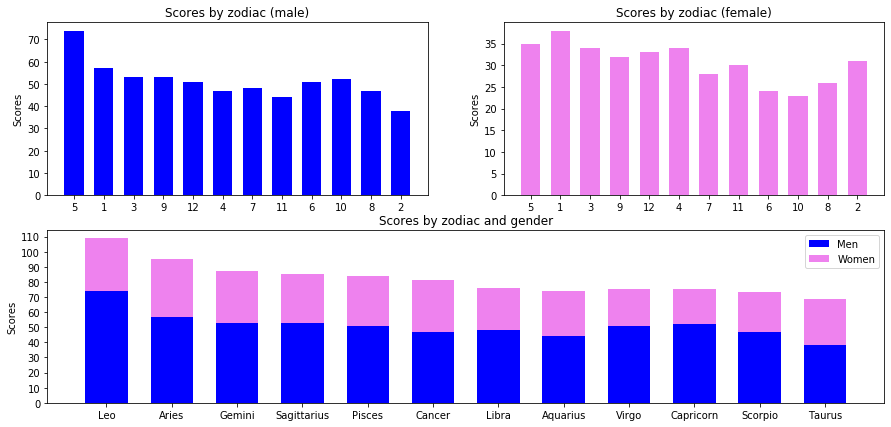

In [180]:
lft_tmp = df[df['male'] == 0]['zodiac'].value_counts()
rgt_tmp = df[df['male'] == 1]['zodiac'].value_counts()
temp_df = pd.merge(lft_tmp,rgt_tmp, left_index=True, right_index=True)
rgt_tmp = df['zodiac'].value_counts()
temp_df = pd.merge(temp_df,rgt_tmp, left_index=True, right_index=True)
temp_df = temp_df.sort_values('zodiac', ascending=False)

fig = plt.figure(figsize= (15,7))
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(212)
width = 0.65

ind = ['5','1','3','9','12','4','7','11','6','10','8','2']
means = temp_df['zodiac_y'].values
ax1.bar(ind, means, width, color='b')
ax1.set_ylabel('Scores')
ax1.set_title('Scores by zodiac (male)')

ind = ['5','1','3','9','12','4','7','11','6','10','8','2']
means = temp_df['zodiac_x'].values
ax2.bar(ind, means, width, color='violet')
ax2.set_ylabel('Scores')
ax2.set_title('Scores by zodiac (female)')

ind = temp_df['zodiac'].index
menMeans = temp_df['zodiac_y'].values
womMeans = temp_df['zodiac_x'].values
ax3.bar(ind, menMeans, width, color='b')
ax3.bar(ind, womMeans, width, bottom=menMeans, color='violet')
ax3.set_ylabel('Scores')
ax3.set_title('Scores by zodiac and gender')
ax3.set_yticks(np.arange(0, 120, 10))
ax3.legend(labels=['Men', 'Women'])

plt.show()

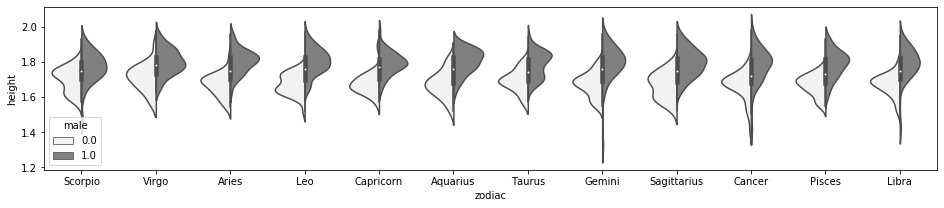

In [217]:
fig = plt.figure(figsize= (16,3))
sns.violinplot(y="height", x="zodiac", hue = 'male', split = True, data=df, color='grey')

In [230]:
df.groupby(by=['male'])['height'].mean()

male
0.0    1.677500
1.0    1.795044
Name: height, dtype: float64

In [232]:
df.year.mean()

1971.375629405841

,rank,name,favors,folders,awards,oscar,nom_oscar,rating,writer,producer,...,genres,chldrns,spouses,total_films,career_start,caree_finish,new_mounth,data,zodiac,united_years
0,1,Михаил Ефремов,695.0,4712,False,0.0,0.0,6.08,1.0,0.0,...,комедия;драма;мелодрама,один;один;один;трое,ася воробьева (развод);евгения добровольская (...,195.0,1976.0,2020.0,11,19631110,Scorpio,1960
1,2,Гай Ричи,5358.0,39893,True,0.0,0.0,7.68,13.0,7.0,...,короткометражка;криминал;боевик,двое;трое,мадонна (развод);джеки эйнсли,62.0,1995.0,2021.0,9,19680910,Virgo,1965
2,3,Мэттью МакКонахи,16535.0,56727,True,1.0,0.0,6.83,1.0,6.0,...,драма;комедия;криминал,трое,камила алвес,209.0,1987.0,2021.0,11,19691104,Scorpio,1965
3,4,Квентин Тарантино,13997.0,73707,True,2.0,0.0,7.47,26.0,20.0,...,комедия;драма;триллер,один,даниэлла пик,218.0,1975.0,2022.0,3,19630327,Aries,1960
4,5,Леонардо ДиКаприо,38557.0,128848,True,1.0,0.0,7.38,1.0,28.0,...,драма;документальный;триллер,NaN,NaN,218.0,1984.0,2021.0,11,19741111,Scorpio,1970
5,6,Том Харди,18927.0,69975,True,0.0,1.0,7.05,2.0,8.0,...,драма;триллер;боевик,двое,сара харди (развод);шарлотта райли,95.0,2001.0,2021.0,9,19770915,Virgo,1975
6,7,Кристофер Нолан,10270.0,59285.0,True,0.0,5.0,7.84,15.0,15.0,...,фантастика;триллер;драма,четверо,эмма томас,70.0,1989.0,2021.0,7,19700730,Leo,1970
7,8,Александра Власова,87.0,489.0,False,0.0,0.0,6.82,0.0,0.0,...,мелодрама;драма;комедия,NaN,NaN,19.0,2013.0,2020.0,1,19900119,Capricorn,1990
8,9,Майкл Шин,881.0,6952.0,True,0.0,0.0,6.95,0.0,4.0,...,драма;комедия;фэнтези,NaN,NaN,165.0,1975.0,2020.0,2,19690205,Aquarius,1965
9,10,Уэс Андерсон,3918.0,19335.0,True,0.0,0.0,7.25,15.0,11.0,...,комедия;драма;короткометражка,NaN,NaN,44.0,1993.0,2020.0,5,19690501,Taurus,1965


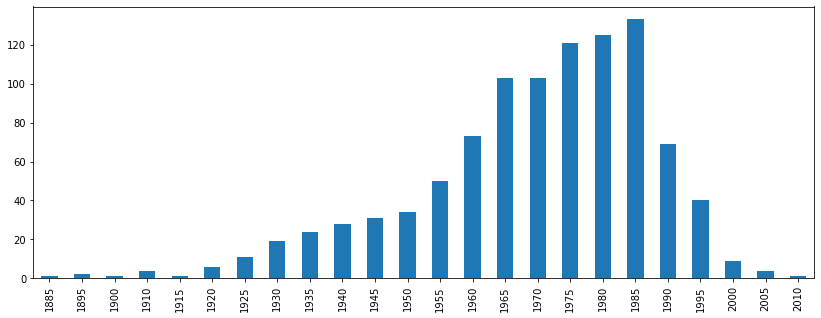

In [240]:
fig = plt.figure(figsize= (14,5))
temp_df = df
temp_df['united_years'] = temp_df['year'].map(lambda x: (x - x%5))
temp_df['united_years'].value_counts(sort=False).plot.bar()
temp_df

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


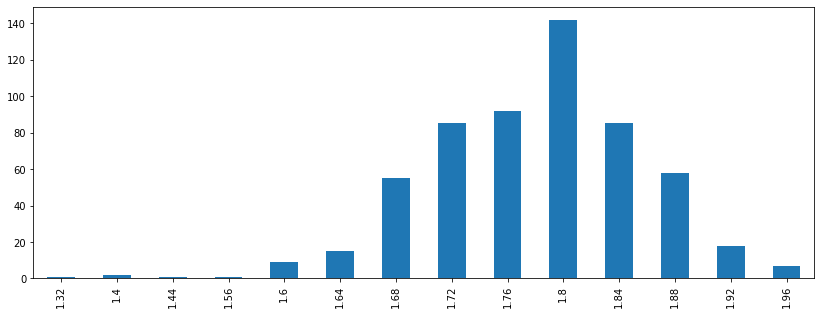

In [188]:
fig = plt.figure(figsize= (14,5))
width = 0.65
# plt.legend(labels=['Men', 'Women'])
temp_df = df[df['male']==1]
temp_df['united_hght'] = temp_df['height'].map(lambda x: ((x*100) - (x*100) % 4)/100)
temp_df['united_hght'].value_counts().sort_index().plot.bar()

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


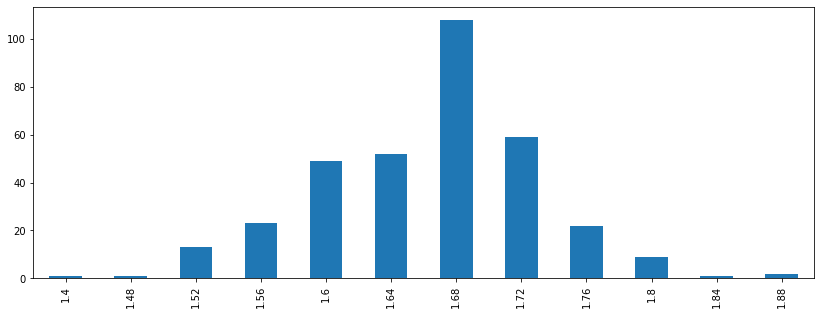

In [189]:
fig = plt.figure(figsize= (14,5))
temp_df = df[df['male']==0]
temp_df['join_hght'] = temp_df['height'].map(lambda x: ((x*100) - (x*100) % 4)/100)
temp_df['join_hght'].value_counts().sort_index().plot.bar()

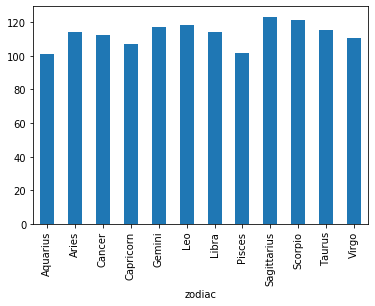

In [376]:
df.groupby(by=['zodiac'])['total_films'].mean().plot.bar()

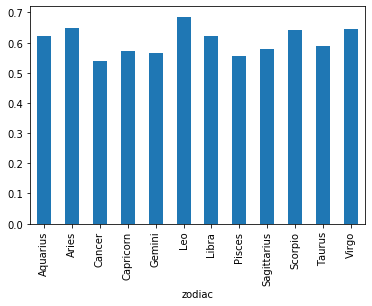

In [377]:
df['awards'] = df['awards'].astype(bool).astype(int)
(df.groupby(by=['zodiac'])['awards'].sum() / df.groupby(by=['zodiac'])['awards'].count()).plot.bar()

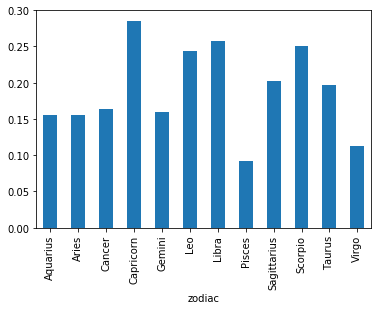

In [378]:
# топ победителей

df['oscar'] = df['oscar'].astype(int)
df['have_oscar'] = df['oscar'].astype(bool).astype(int)
(df.groupby(by=['zodiac'])['have_oscar'].sum() / df.groupby(by=['zodiac'])['have_oscar'].count()).plot.bar()

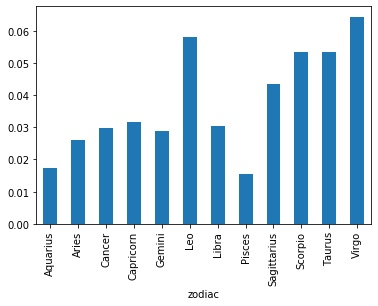

In [379]:
# топ неудачников

df['nom_oscar'] = df['nom_oscar'].astype(int)
df['have_nom_oscar'] = df['nom_oscar'].astype(bool).astype(int)
(df.groupby(by=['zodiac'])['have_nom_oscar'].sum() / df.groupby(by=['zodiac'])\
     ['have_nom_oscar'].count()).plot.bar()

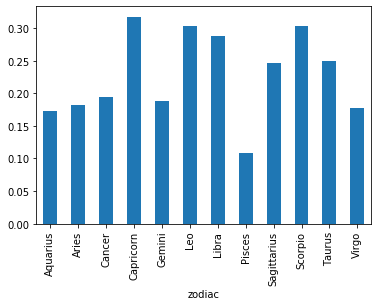

In [380]:
# топ номинирующихся+ на оскар

df['have_oscar_or_nom_oscar'] = (df['nom_oscar'] + df['oscar']).astype(bool).astype(int)
(df.groupby(by=['zodiac'])['have_oscar_or_nom_oscar'].sum() / df.groupby(by=['zodiac'])\
    ['have_oscar_or_nom_oscar'].count()).plot.bar()

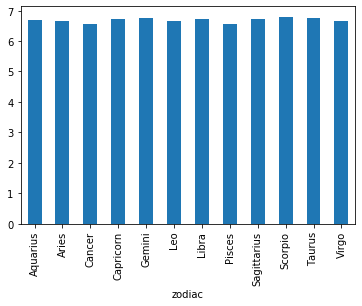

In [385]:
temp_df = df[df['male']==0]
temp_df.groupby(by=['zodiac'])['rating'].mean().plot.bar()

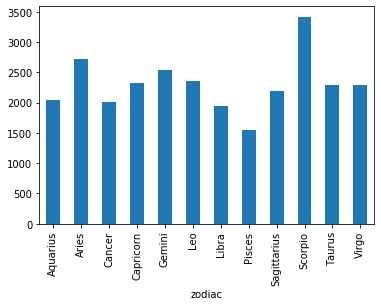

In [381]:
df.groupby(by=['zodiac'])['favors'].mean().plot.bar()

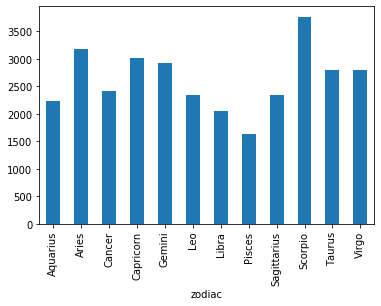

In [382]:
temp_df = df[df['male']==1]
temp_df.groupby(by=['zodiac'])['favors'].mean().plot.bar()

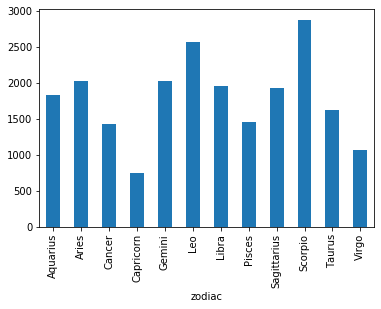

In [383]:
temp_df = df[df['male']==0]
temp_df.groupby(by=['zodiac'])['favors'].mean().plot.bar()

In [340]:
df['folders'] = df['folders'].astype(float)
df.groupby(by=['zodiac'])['folders'].mean().plot.bar()

ValueError: could not convert string to float: 'None'